In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the "../input/" directory.http://localhost:8925/notebooks/OneDrive/Desktop/Computer_Vision_finalPJ/captcha-recognition-26d064.ipynb#
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
%matplotlib inline 
import matplotlib.pyplot as plt
import os
print(os.listdir("./input"))

# Any results you write to the current directory are saved as output.

['captcha-version-2-images', 'capthaimages']


In [2]:
from keras import layers
from keras.models import Model
from keras.models import load_model
from keras import callbacks
import os
import cv2
import string
import numpy as np

#Init main values
symbols = string.ascii_lowercase + "0123456789" # All symbols captcha can contain
num_symbols = len(symbols)
img_shape = (50, 200, 1)

In [3]:
print(num_symbols)

36


In [4]:
def create_model():
    img = layers.Input(shape=img_shape) # Get image as an input and process it through some Convs
    conv1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(img)
    mp1 = layers.MaxPooling2D(padding='same')(conv1)  # 100x25
    conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp1)
    mp2 = layers.MaxPooling2D(padding='same')(conv2)  # 50x13
    conv3 = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(mp2)
    bn = layers.BatchNormalization()(conv3)
    mp3 = layers.MaxPooling2D(padding='same')(bn)  # 25x7
    
    # Get flattened vector and make 5 branches from it. Each branch will predict one letter
    flat = layers.Flatten()(mp3)
    outs = []
    for _ in range(5):
        dens1 = layers.Dense(64, activation='relu')(flat)
        drop = layers.Dropout(0.5)(dens1)
        res = layers.Dense(num_symbols, activation='sigmoid')(drop)

        outs.append(res)
    
    # Compile model and return it
    model = Model(img, outs)
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])
    return model

In [5]:
def preprocess_data():
    n_samples = len(os.listdir('./input/captcha-version-2-images'))
    X = np.zeros((n_samples, 50, 200, 1)) #1070*50*200
    y = np.zeros((5, n_samples, num_symbols)) #5*1070*36

    for i, pic in enumerate(os.listdir('./input/captcha-version-2-images')):
        # Read image as grayscale
        img = cv2.imread(os.path.join('./input/captcha-version-2-images', pic), cv2.IMREAD_GRAYSCALE)
        pic_target = pic[:-4]
        if len(pic_target) < 6:
            # Scale and reshape image
            img = img / 255.0
            img = np.reshape(img, (50, 200, 1))
            # Define targets and code them using OneHotEncoding
            targs = np.zeros((5, num_symbols))
            for j, l in enumerate(pic_target):
                ind = symbols.find(l)
                targs[j, ind] = 1
            X[i] = img
            y[:, i] = targs
    
    # Return final data
    return X, y

X, y = preprocess_data()
X_train, y_train = X[:970], y[:, :970]
X_test, y_test = X[970:], y[:, 970:]

In [6]:
model=create_model();
model.summary();

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 200, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 50, 200, 16)  160         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 25, 100, 16)  0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 25, 100, 32)  4640        ['max_pooling2d[0][0]']      

In [7]:
#model = create_model()
hist = model.fit(X_train, [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]], batch_size=32, epochs=30,verbose=1, validation_split=0.2)

Epoch 1/30
25/25 [==============================] - 6s 163ms/step - loss: 17.8299 - dense_1_loss: 3.4832 - dense_3_loss: 3.5842 - dense_5_loss: 3.5963 - dense_7_loss: 3.5793 - dense_9_loss: 3.5869 - dense_1_accuracy: 0.0593 - dense_3_accuracy: 0.0631 - dense_5_accuracy: 0.0644 - dense_7_accuracy: 0.0606 - dense_9_accuracy: 0.0528 - val_loss: 17.7263 - val_dense_1_loss: 3.6053 - val_dense_3_loss: 3.5367 - val_dense_5_loss: 3.5305 - val_dense_7_loss: 3.5350 - val_dense_9_loss: 3.5188 - val_dense_1_accuracy: 0.0000e+00 - val_dense_3_accuracy: 0.1031 - val_dense_5_accuracy: 0.0979 - val_dense_7_accuracy: 0.0979 - val_dense_9_accuracy: 0.1082
Epoch 2/30
25/25 [==============================] - 3s 135ms/step - loss: 16.3869 - dense_1_loss: 3.0647 - dense_3_loss: 3.2720 - dense_5_loss: 3.3583 - dense_7_loss: 3.3567 - dense_9_loss: 3.3352 - dense_1_accuracy: 0.1031 - dense_3_accuracy: 0.0941 - dense_5_accuracy: 0.0683 - dense_7_accuracy: 0.0735 - dense_9_accuracy: 0.0928 - val_loss: 17.6296 - 

Epoch 14/30
25/25 [==============================] - 3s 133ms/step - loss: 4.7037 - dense_1_loss: 0.2633 - dense_3_loss: 0.6859 - dense_5_loss: 1.0864 - dense_7_loss: 1.4193 - dense_9_loss: 1.2487 - dense_1_accuracy: 0.9046 - dense_3_accuracy: 0.7487 - dense_5_accuracy: 0.6121 - dense_7_accuracy: 0.4910 - dense_9_accuracy: 0.5657 - val_loss: 11.5267 - val_dense_1_loss: 4.8583 - val_dense_3_loss: 1.3187 - val_dense_5_loss: 1.6476 - val_dense_7_loss: 1.9114 - val_dense_9_loss: 1.7908 - val_dense_1_accuracy: 0.0258 - val_dense_3_accuracy: 0.8247 - val_dense_5_accuracy: 0.6907 - val_dense_7_accuracy: 0.6340 - val_dense_9_accuracy: 0.6134
Epoch 15/30
25/25 [==============================] - 3s 137ms/step - loss: 4.3388 - dense_1_loss: 0.2268 - dense_3_loss: 0.6721 - dense_5_loss: 0.9551 - dense_7_loss: 1.2970 - dense_9_loss: 1.1876 - dense_1_accuracy: 0.9278 - dense_3_accuracy: 0.7552 - dense_5_accuracy: 0.6521 - dense_7_accuracy: 0.5399 - dense_9_accuracy: 0.5786 - val_loss: 11.8238 - val_

Epoch 27/30
25/25 [==============================] - 3s 126ms/step - loss: 2.2085 - dense_1_loss: 0.1230 - dense_3_loss: 0.3125 - dense_5_loss: 0.5009 - dense_7_loss: 0.7109 - dense_9_loss: 0.5612 - dense_1_accuracy: 0.9523 - dense_3_accuracy: 0.8827 - dense_5_accuracy: 0.8054 - dense_7_accuracy: 0.7371 - dense_9_accuracy: 0.8041 - val_loss: 18.7861 - val_dense_1_loss: 15.3345 - val_dense_3_loss: 0.7124 - val_dense_5_loss: 1.0678 - val_dense_7_loss: 1.0423 - val_dense_9_loss: 0.6290 - val_dense_1_accuracy: 0.0052 - val_dense_3_accuracy: 0.8763 - val_dense_5_accuracy: 0.7474 - val_dense_7_accuracy: 0.7320 - val_dense_9_accuracy: 0.8041
Epoch 28/30
25/25 [==============================] - 3s 130ms/step - loss: 2.0258 - dense_1_loss: 0.0979 - dense_3_loss: 0.2637 - dense_5_loss: 0.4991 - dense_7_loss: 0.6619 - dense_9_loss: 0.5031 - dense_1_accuracy: 0.9652 - dense_3_accuracy: 0.9034 - dense_5_accuracy: 0.8286 - dense_7_accuracy: 0.7384 - dense_9_accuracy: 0.8131 - val_loss: 16.3718 - val

In [8]:
# Define function to predict captcha
def predict(filepath):
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img = img / 255.0
    else:
        print("Not detected");
    res = np.array(model.predict(img[np.newaxis, :, :, np.newaxis]))
    ans = np.reshape(res, (5, 36))
    l_ind = []
    probs = []
    for a in ans:
        l_ind.append(np.argmax(a))
        #probs.append(np.max(a))

    capt = ''
    for l in l_ind:
        capt += symbols[l]
    return capt#, sum(probs) / 5



In [9]:
score= model.evaluate(X_test,[y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]],verbose=1)
print('Test Loss and accuracy:', score)

4/4 [==============================] - 0s 17ms/step - loss: 16.2728 - dense_1_loss: 14.2163 - dense_3_loss: 0.1669 - dense_5_loss: 0.4782 - dense_7_loss: 0.8415 - dense_9_loss: 0.5698 - dense_1_accuracy: 0.0000e+00 - dense_3_accuracy: 0.9400 - dense_5_accuracy: 0.8400 - dense_7_accuracy: 0.7600 - dense_9_accuracy: 0.8600
Test Loss and accuracy: [16.272777557373047, 14.216338157653809, 0.1669446974992752, 0.47816789150238037, 0.8414819836616516, 0.5698450207710266, 0.0, 0.9399999976158142, 0.8399999737739563, 0.7599999904632568, 0.8600000143051147]


In [10]:
#Create a Drawing Function
def show_train_history(train_history,train,validation,label):
    #Write the code
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title("Train History")
    plt.ylabel(label)
    plt.xlabel("Epoch")
    plt.legend(['train','validation'],loc='upper left')
    plt.show()

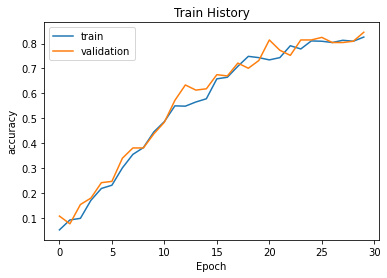

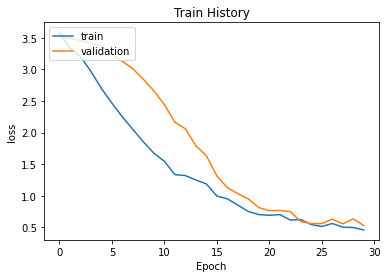

In [13]:
show_train_history(hist,'dense_9_accuracy','val_dense_9_accuracy','accuracy')
show_train_history(hist,'dense_9_loss','val_dense_9_loss','loss')

In [ ]:
# Check model on some samples
model.evaluate(X_test, [y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]])
print(predict('./input/captcha-version-2-images/8n5p3.png'))
print(predict('./input/captcha-version-2-images/f2m8n.png'))
print(predict('./input/captcha-version-2-images/dce8y.png'))
print(predict('./input/captcha-version-2-images/3eny7.png'))
print(predict('./input/captcha-version-2-images/npxb7.png'))

In [ ]:
#Lets test an unknown captcha
#preview
%matplotlib inline 
import matplotlib.pyplot as plt
img=cv2.imread('./input/capthaimages/a.png',cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap=plt.get_cmap('gray'))

In [ ]:
#Lets Predict By Model
print("Predicted Captcha =",predict('./input/capthaimages/a.png'))

In [ ]:
#testing
#c=0
#for i, pic in enumerate(os.listdir('../input/captcha-version-2-images/samples/samples')):
        # Read image as grayscale
        
        #if i>970:    

            #img = cv2.imread(os.path.join('../input/captcha-version-2-images/samples/samples', pic), cv2.IMREAD_GRAYSCALE)
            #print("Predicted Captcha =",predict(os.path.join('../input/captcha-version-2-images/samples/samples',pic)))
            #plt.imshow(img, cmap=plt.get_cmap('gray'))
            #pr=predict(os.path.join('../input/captcha-version-2-images/samples/samples',pic))
            #pic_target = pic[:-4]
            #if pr==pic_target:
                #c=c+1
                #print(c)
            #print(pic_target)
#print((c/100)*100)